We'll start by using the [markovify](https://github.com/jsvine/markovify/) library to make some social-media-sized utterances in the style of Jane Austen.  This will be the basis for generating a synthetic social media stream.

In [1]:
import markovify
import codecs

with codecs.open("data/austen.txt", "r", "cp1252") as f:
    text = f.read()

austen_model = markovify.Text(text, retain_original=False, state_size=3)

for i in range(10):
    print(austen_model.make_short_sentence(200))

No!
In spite of this amendment, however, she requested to have a nearer view of their characters and her own spirits, were at least very certain; and she joined Mrs. Jennings in the drawing-room for me.
When alone with Elizabeth afterwards, she spoke more on the subject; and her father was universally civil, but not one with such justice.
After being nursed up at Mansfield, it was too late to be saving.
The journey was likely to be good.
The work of one moment was destroyed by the next.
Catherine's spirits revived as they drove up to the yard-arm.
She had a sister married to a Miss Hawkins.
It might not be thought of: he was very much obliged to her for the world.
I was never so enraged before, and must relieve myself by writing to you, for I do not think any young woman who had listened and seemed to think it as much her duty as Mrs. Weston's to receive them.


We'll use spaCy to identify entities (mostly proper nouns and noun phrases) in these synthetic status updates and turn them into hashtags:

In [2]:
import spacy
nlp = spacy.load('en')

def make_sentence(model, length=200):
    return model.make_short_sentence(length)
    
def hashtagify_full(sentence):
    doc = nlp(sentence)
    for ent in doc.ents:
        sentence = sentence.replace(str(ent), "#%s" % str(ent).replace(" ", ""))
    return (sentence, ["#%s" % str(ent).replace(" ", "") for ent in doc.ents])

def hashtagify(sentence):
    result,_ = hashtagify_full(sentence)
    return result

for i in range(5):
    sentence = make_sentence(austen_model)
    print(sentence)
    print(hashtagify(sentence))

Her congratulations were warm and open; but Emma could not but dispose them all to go back into Norfolk directly, and put everything at once on such a point, without being resented.
Her congratulations were warm and open; but #Emma could not but dispose them all to go back into #Norfolk directly, and put everything at once on such a point, without being resented.
Charming people, Mr. and Mrs. Perry.
Charming people, Mr. and Mrs. #Perry.
Fanny looked very angry too, and her husband away, she can have nothing to say or to hear that Mrs. Ferrars considered it in that light; a very gratifying circumstance you know to us all.
#Fanny looked very angry too, and her husband away, she can have nothing to say or to hear that Mrs. #Ferrars considered it in that light; a very gratifying circumstance you know to us all.
He stopped in his earnestness to look the question, and the gentlemen did not disdain.
He stopped in his earnestness to look the question, and the gentlemen did not disdain.
To be f

We'll now train two Markov models on positive and negative product reviews (taken from the [public-domain Amazon fine foods reviews dataset on Kaggle](https://www.kaggle.com/snap/amazon-fine-food-reviews/)).  We'll incorporate the results of these models into our synthetic social media stream.

In [3]:
import gzip

def train_markov_gz(fn):
    """ trains a Markov model on gzipped text data """
    with gzip.open(fn, "rt", encoding="utf-8") as f:
        text = f.read()
    return markovify.Text(text, retain_original=False, state_size=3)

negative_model = train_markov_gz("data/reviews-1.txt.gz")
positive_model = train_markov_gz("data/reviews-5-100k.txt.gz")

In [4]:
make_sentence(negative_model)

'Most movie theaters have finally changed from coconut oil to canola or other good oils to address this major health concern and bad press over the years.'

In [5]:
make_sentence(positive_model)

'The garlic flavor is pervasive throughout, and it is a perfect size; you get a fresh product.While they could do for me.'

We can combine these models with relative weights, but this yields somewhat unusual results:

In [6]:
compound_model = markovify.combine([austen_model, negative_model, positive_model], [14, 3, 3])

In [7]:
for i in range(20):
    print(hashtagify(make_sentence(compound_model)))

Rather it's a much healthier bone or treat than most stuff on the planet.
But it is done; we are reconciled, dearer, much dearer, than ever, and with eyes closed, as if the beans are in #BPA free plastic.
She drinks tea #everynight for #10years ! It is the species #Mentha arvensis.
No complaints.
He engaged to be with the #Musgroves from breakfast to dinner.
Other teas are bitter in comparison.Try it you'll like it.
Perfect for quashing that sweet craving without breaking my extremely low calorie diet.
The package I received #today.
There's no way this was random either.
We found it so difficult to chew.#Described as the perfect gift and I will go back to Raw Revolution.This bar is disgusting ...
I hadn't made jam in over #tenyears, so I wasn't sure what the other reviewers are thinking when they created this variety box if you buy this your nuts.
The only reason I gave this a try..This does NOT taste anything like these beverages and you don't want the liability of these items in the 

As is more or less the case in the real world, we'll assume that a small percentage of users are responsible for the bulk of social media activity, and that the bulk of users are responsible for relatively few posts.  We'll model this with a table of random user IDs that has a collection of relatively few talkative users and relatively many moderate users; the proportion of utterances from talkative users to utterances from moderate users is the inverse of the proportion of talkative users to moderate users.

In [8]:
import numpy
import math
import collections

class UserTable(object):
    def __init__(self, size, weights=[8, 2]):
        self._talkative = collections.deque()
        self._moderate = collections.deque()
        self._size = size
        self._cutoff = float(weights[0]) / sum(weights)
        
        for i in range(size):
            new_uid = math.floor(numpy.random.uniform(10 ** 10))
            if numpy.random.uniform() >= self._cutoff:
                self._moderate.append(new_uid)
            else:
                self._talkative.append(new_uid)
    
    def random_uid(self):
        def choose_from(c):
            return c[math.floor(numpy.random.uniform() * len(c))]
        
        if numpy.random.uniform() >= self._cutoff:
            return choose_from(self._talkative)
        else:
            return choose_from(self._moderate)
        

In [9]:
import seaborn

We can see the number of times each user ID appears if we ask the `UserTable` for 1000 random user IDs:

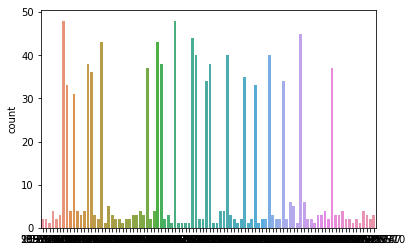

In [10]:
ut = UserTable(100)
uids = [ut.random_uid() for i in range(1000)]
seaborn.countplot(uids)

In [11]:
def generate_tweets(models, weights=None, hashtag_weights=[8, 2], ut=None, seed_hashtags=[]):
    if weights is None:
        weights = [1] * len(models)
    
    if ut is None:
        ut = UserTable(10000)
    
    choices = []
    
    total_weight = float(sum(weights))
    
    for i in range(len(weights)):
        choices.append((float(sum(weights[0:i+1])) / total_weight, models[i]))
    
    def choose_model():
        r = numpy.random.uniform()
        for (p, m) in choices:
            if r <= p:
                return m
        return choices[-1][1]
    
    seen_hashtags = set()
    hashtags = []
    total_hashtag_weight = float(sum(hashtag_weights))
    for i in range(len(hashtag_weights)): 
        hashtags.append((float(sum(hashtag_weights[0:i+1])) / total_hashtag_weight, collections.deque()))
    
    iws = [1.0 - w for (w, _) in hashtags]
    inverse_weights = [(sum(iws[0:i+1]), i) for _, i in zip(iws, range(len(iws)))]    

    def choose_from(c):
        idx = math.floor(numpy.random.uniform() * len(c))
        return c[idx]
    
    def store_hashtag(tag):
        if tag not in seen_hashtags:
            seen_hashtags.add(str(tag))
            r = numpy.random.uniform()
            for(p, deq) in hashtags:
                if r <= p:
                    deq.append(tag)
    
    def choose_hashtag():
        r = numpy.random.uniform()
        for(p, i) in hashtags:
            if r <= - p and len(hashtags[i][1]) > 0:
                return choose_from(hashtags[i][1])
        return len(hashtags[0][1]) > 0 and choose_from(hashtags[0][1]) or choose_from(hashtags[1][1])
    
    for tag in seed_hashtags:
        seen_hashtags.add(str(tag))
        hashtags[-1][1].append(str(tag))
    
    while True:
        tweet, tags = hashtagify_full(make_sentence(choose_model()))
        for tag in tags:
            store_hashtag(str(tag))
        
        this_tweet_tags = set([str(t) for t in tags])
        
        if len(seen_hashtags) > 0:
            for i in range(min(numpy.random.poisson(3), len(seen_hashtags))):
                tag = choose_hashtag()
                if str(tag) not in this_tweet_tags:
                    this_tweet_tags.add(str(tag))
                    tweet += " %s" % str(tag)
            
        yield (ut.random_uid(), tweet)

In [12]:
seed_hashtags=["#ff", "#marketing", "#fail", "#followfriday", "#yolo", "#retweet", "#tbt", "#socialmedia", "#startup", "#blogpost", "#news", "#health"]

t = generate_tweets([austen_model, positive_model, negative_model, compound_model], [22, 4, 4, 2], seed_hashtags=seed_hashtags)

In [13]:
t

<generator object generate_tweets at 0x15a724fc0>

In [14]:
[next(t) for i in range(100)]

[(7350786372,
  'I was delighted to find these 8-pack bundles available on #Amazon at such a good product.'),
 (6597221724, 'It will be well pleased. #Amazon'),
 (1166998778,
  'Emma hung about him affectionately, and smiled, and hoped her turn was coming soon. #Amazon'),
 (8815084594,
  'A long grain, but it is not the abswer to your problems. #Amazon'),
 (8660921049,
  'Everybody was surprised, and #Darcy, after looking at her mother, she is saving enough. #Amazon'),
 (1283837519,
  '#DIAMOND MAKES A GOOD PRODUCT AND THESE #WALNUTS ARE DELICIOUS ON THEIR OWN AS A SNACK AND SHE LOVES THEM. #Darcy'),
 (6392744288,
  'I am myself partial to the house together, there to lounge away the time as they could after dinner; and every one concerned was looking forward with eagerness. #DIAMOND #Darcy'),
 (4461427418, 'My cat loves these. #Darcy #DIAMOND #Amazon'),
 (4125085827,
  'The most trivial, paltry, insignificant part; the merest commonplace; not a tolerable speech in the whole. #DIAMOND'

In [15]:
import cProfile

def timing(c):
    for _ in range(c):
        next(t)

cProfile.run('timing(2000)', 'generatestats')

In [16]:
import pstats
p = pstats.Stats('generatestats')
p.strip_dirs().sort_stats(-1).print_stats()

Mon Feb 18 19:34:03 2019    generatestats

         8231432 function calls (8057651 primitive calls) in 23.246 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
3998/2000    0.068    0.000   21.346    0.011 <ipython-input-11-22f0f6476ec7>:1(generate_tweets)
     2000    0.003    0.000    0.006    0.000 <ipython-input-11-22f0f6476ec7>:15(choose_model)
     5939    0.012    0.000    0.026    0.000 <ipython-input-11-22f0f6476ec7>:31(choose_from)
     1229    0.004    0.000    0.009    0.000 <ipython-input-11-22f0f6476ec7>:35(store_hashtag)
     5939    0.015    0.000    0.054    0.000 <ipython-input-11-22f0f6476ec7>:43(choose_hashtag)
     2000    0.001    0.000    0.001    0.000 <ipython-input-11-22f0f6476ec7>:59(<listcomp>)
      2/1    0.000    0.000    0.009    0.009 <ipython-input-15-801ca619797e>:3(timing)
     2000    0.007    0.000    0.010    0.000 <ipython-input-2-ff5f1bd7c840>:11(<listcomp>)
     2000    0.005    0.00